In [1]:
import pandas as pd
import numpy as np


from sklearn.metrics import roc_auc_score

from sklearn.model_selection import StratifiedKFold


from sklearn.ensemble import RandomForestClassifier
%pip install xgboost lightgbm catboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from scipy.stats import loguniform

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
train_df = pd.read_csv("C:/Users/divya/OneDrive/Desktop/Data Science Lab/project/train.csv")
test_df = pd.read_csv("C:/Users/divya/OneDrive/Desktop/Data Science Lab/project/test.csv")
sub_df = pd.read_csv("C:/Users/divya/OneDrive/Desktop/Data Science Lab/project/sample_submission.csv")

In [3]:
original_train_df = pd.read_csv("C:\\Users\\divya\\OneDrive\\Desktop\\Data Science Lab\\project\\train_dataset.csv")
original_test_df = pd.read_csv("C:\\Users\\divya\\OneDrive\\Desktop\\Data Science Lab\\project\\test_dataset.csv")

In [4]:

from sklearn.feature_selection import mutual_info_classif


In [5]:

# Simple preprocessing
X = train_df.drop(columns=["id", "smoking"])
y = train_df["smoking"]
X_test = test_df.drop(columns=["id"])

# Train a basic LGBMClassifier
model = LGBMClassifier(random_state=42)
model.fit(X, y)

# Predict
test_preds = model.predict_proba(X_test)[:, 1]  # probability for class 1

# Prepare submission
sub_df["smoking"] = test_preds
sub_df.to_csv("C:/Users/divya/OneDrive/Desktop/sub_lgbm_tuning.csv", index=False)
print("Submission file saved!")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 69653, number of negative: 89603
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2177
[LightGBM] [Info] Number of data points in the train set: 159256, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437365 -> initscore=-0.251863
[LightGBM] [Info] Start training from score -0.251863
Submission file saved!


In [6]:

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
import numpy as np

# 1. Feature Selection using Mutual Information
X = train_df.drop(columns=["id", "smoking"])
y = train_df["smoking"]
X_test = test_df.drop(columns=["id"])

mi_scores = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Select top 15 features
top_features = mi_series.head(15).index.tolist()
X_selected = X[top_features]
X_test_selected = X_test[top_features]

# 2. Model Tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

model = LGBMClassifier(random_state=42)
grid = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
grid.fit(X_selected, y)

print("Best Parameters:", grid.best_params_)
print("Best CV ROC AUC:", grid.best_score_)

# 3. Cross-Validation Scores with best model
cv_scores = cross_val_score(grid.best_estimator_, X_selected, y, cv=5, scoring='roc_auc')
print("Cross-Validated ROC AUC Scores:", cv_scores)
print("Mean ROC AUC:", np.mean(cv_scores))

# 4. Final Predictions
test_preds = grid.best_estimator_.predict_proba(X_test_selected)[:, 1]
sub_df["smoking"] = test_preds
sub_df.to_csv("C:/Users/divya/OneDrive/Desktop/sub_lgbm_tuned.csv", index=False)
print("Tuned submission file saved!")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 69653, number of negative: 89603
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1320
[LightGBM] [Info] Number of data points in the train set: 159256, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437365 -> initscore=-0.251863
[LightGBM] [Info] Start training from score -0.251863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best CV ROC AUC: 0.8602494159779253
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 55722, number of negative: 71682
[LightGBM] [Info] Auto-ch

In [7]:
train_df.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


In [8]:
train_df['Source'] = 'Competition'
test_df['Source'] = 'Competition'
original_train_df['Source'] = 'Original'
original_test_df['Source'] = 'Original'

train_df['DSType'] = 'Train' 
test_df['DSType'] = 'Test' 
original_train_df['DSType'] = 'Train'
original_test_df['DSType'] = 'Test'

In [9]:
test_df

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,Source,DSType
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,...,115,14.2,1,0.9,19,25,32,0,Competition,Test
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,...,104,13.0,1,1.1,20,12,24,0,Competition,Test
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,...,88,15.4,1,1.4,38,60,36,0,Competition,Test
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,...,128,14.5,1,0.6,25,18,10,1,Competition,Test
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,...,123,16.5,1,1.0,30,39,27,1,Competition,Test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106166,265422,40,165,60,78.0,0.8,0.9,1,1,112,...,149,16.4,1,1.1,24,31,28,0,Competition,Test
106167,265423,40,170,85,95.0,1.2,1.2,1,1,130,...,100,16.0,2,1.0,25,31,38,0,Competition,Test
106168,265424,35,170,85,89.0,1.2,1.2,1,1,131,...,142,15.9,1,0.8,33,32,24,1,Competition,Test
106169,265425,40,160,60,67.0,0.7,0.8,1,1,120,...,103,13.9,1,0.6,42,36,32,0,Competition,Test


In [10]:
for df in [train_df, test_df, original_train_df, original_test_df]:
    df.drop_duplicates(keep='first', inplace=True)

In [11]:
for df in [train_df, test_df, original_train_df, original_test_df]:
    df.rename({
        'height(cm)': 'height',
        'weight(kg)': 'weight',
        'waist(cm)': 'waist',
        'eyesight(left)': 'eyesight_left',
        'eyesight(right)': 'eyesight_right',
        'hearing(left)': 'hearing_left',
        'hearing(right)': 'hearing_right',
        'fasting blood sugar': 'fasting_blood_sugar',
        'Urine protein': 'urine_protein',
        'serum creatinine': 'serum_creatinine',
        'dental caries': 'dental_caries'
    }, axis=1, inplace=True)


In [12]:
concat_df = pd.concat([train_df, test_df, original_train_df, original_test_df]).copy()
concat_df.reset_index(drop=True, inplace=True)
concat_df.drop(columns='id', inplace=True)


In [13]:
concat_df


,age,height,weight,waist,eyesight_left,eyesight_right,hearing_left,hearing_right,systolic,relaxation,...,hemoglobin,urine_protein,serum_creatinine,AST,ALT,Gtp,dental_caries,smoking,Source,DSType
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,16.5,1,1.0,22,25,27,0,1.0,Competition,Train
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,16.2,1,1.1,27,23,37,1,0.0,Competition,Train
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,17.4,1,0.8,27,31,53,0,1.0,Competition,Train
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,15.9,1,1.0,20,27,30,1,0.0,Competition,Train
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,15.4,1,0.8,19,13,17,0,1.0,Competition,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314599,60,165,65,82.0,0.7,1.0,1,1,101,68,...,13.5,1,0.8,78,75,33,0,NaN,Original,Test
314600,60,155,70,93.0,0.8,1.0,1,1,134,70,...,13.9,1,0.7,19,28,28,1,NaN,Original,Test
314601,40,155,50,67.2,0.9,0.8,1,1,134,80,...,13.4,1,0.7,16,10,14,0,NaN,Original,Test
314602,35,165,70,76.1,1.0,1.0,1,1,114,68,...,14.3,1,1.2,19,28,30,1,NaN,Original,Test


In [14]:
concat_df.dtypes

age                      int64
height                   int64
weight                   int64
waist                  float64
eyesight_left          float64
eyesight_right         float64
hearing_left             int64
hearing_right            int64
systolic                 int64
relaxation               int64
fasting_blood_sugar      int64
Cholesterol              int64
triglyceride             int64
HDL                      int64
LDL                      int64
hemoglobin             float64
urine_protein            int64
serum_creatinine       float64
AST                      int64
ALT                      int64
Gtp                      int64
dental_caries            int64
smoking                float64
Source                  object
DSType                  object
dtype: object

In [15]:
concat_df.isna().sum()

age                         0
height                      0
weight                      0
waist                       0
eyesight_left               0
eyesight_right              0
hearing_left                0
hearing_right               0
systolic                    0
relaxation                  0
fasting_blood_sugar         0
Cholesterol                 0
triglyceride                0
HDL                         0
LDL                         0
hemoglobin                  0
urine_protein               0
serum_creatinine            0
AST                         0
ALT                         0
Gtp                         0
dental_caries               0
smoking                121881
Source                      0
DSType                      0
dtype: int64

EDA, Feature Engineering and Preprocessing

In [16]:
concat_df['smoking'].value_counts(normalize=True)

smoking
0.0    0.574981
1.0    0.425019
Name: proportion, dtype: float64

In [17]:
numeric_cols = ['age', 'height', 'weight', 'waist',
                'eyesight_left', 'eyesight_right', 'systolic',
                'relaxation', 'fasting_blood_sugar', 'Cholesterol',
                'triglyceride', 'HDL', 'LDL', 'hemoglobin', 
                'serum_creatinine', 'AST', 'ALT', 'Gtp']
numerics = list(concat_df[numeric_cols])

In [18]:
all_cols = concat_df.columns.tolist()[:-3]
alls = list(concat_df[all_cols])

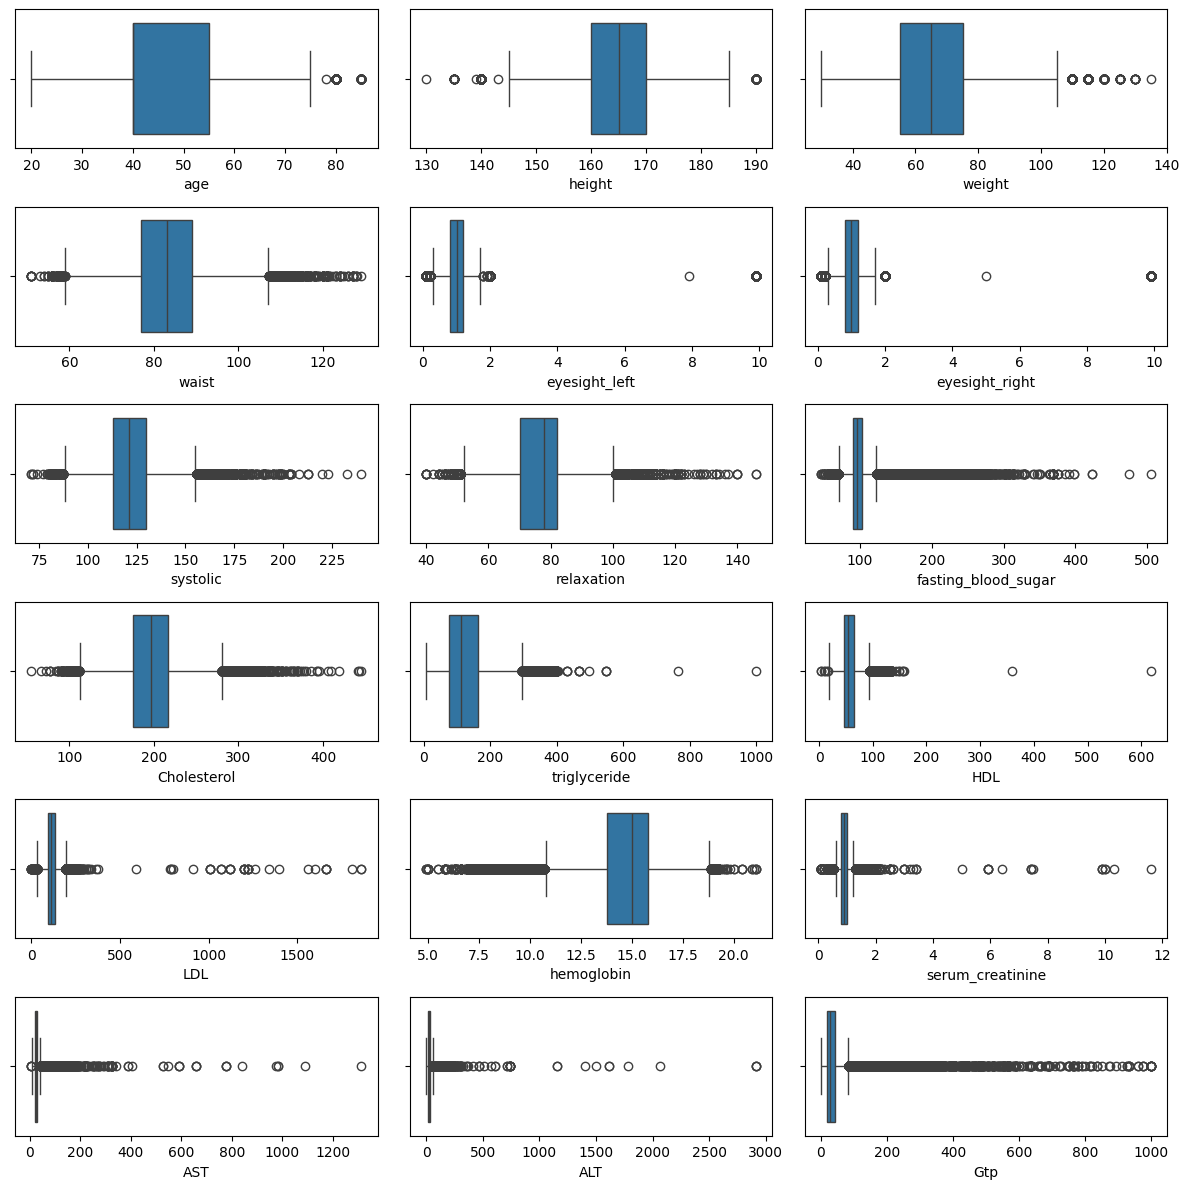

In [19]:
fig, ax = plt.subplots(int((len(numerics)/3)), 3, figsize = (12, 12))
ax = ax.flatten()

for i, column in enumerate(numerics): 
    sns.boxplot(x=concat_df[column], ax=ax[i])
    
plt.tight_layout()

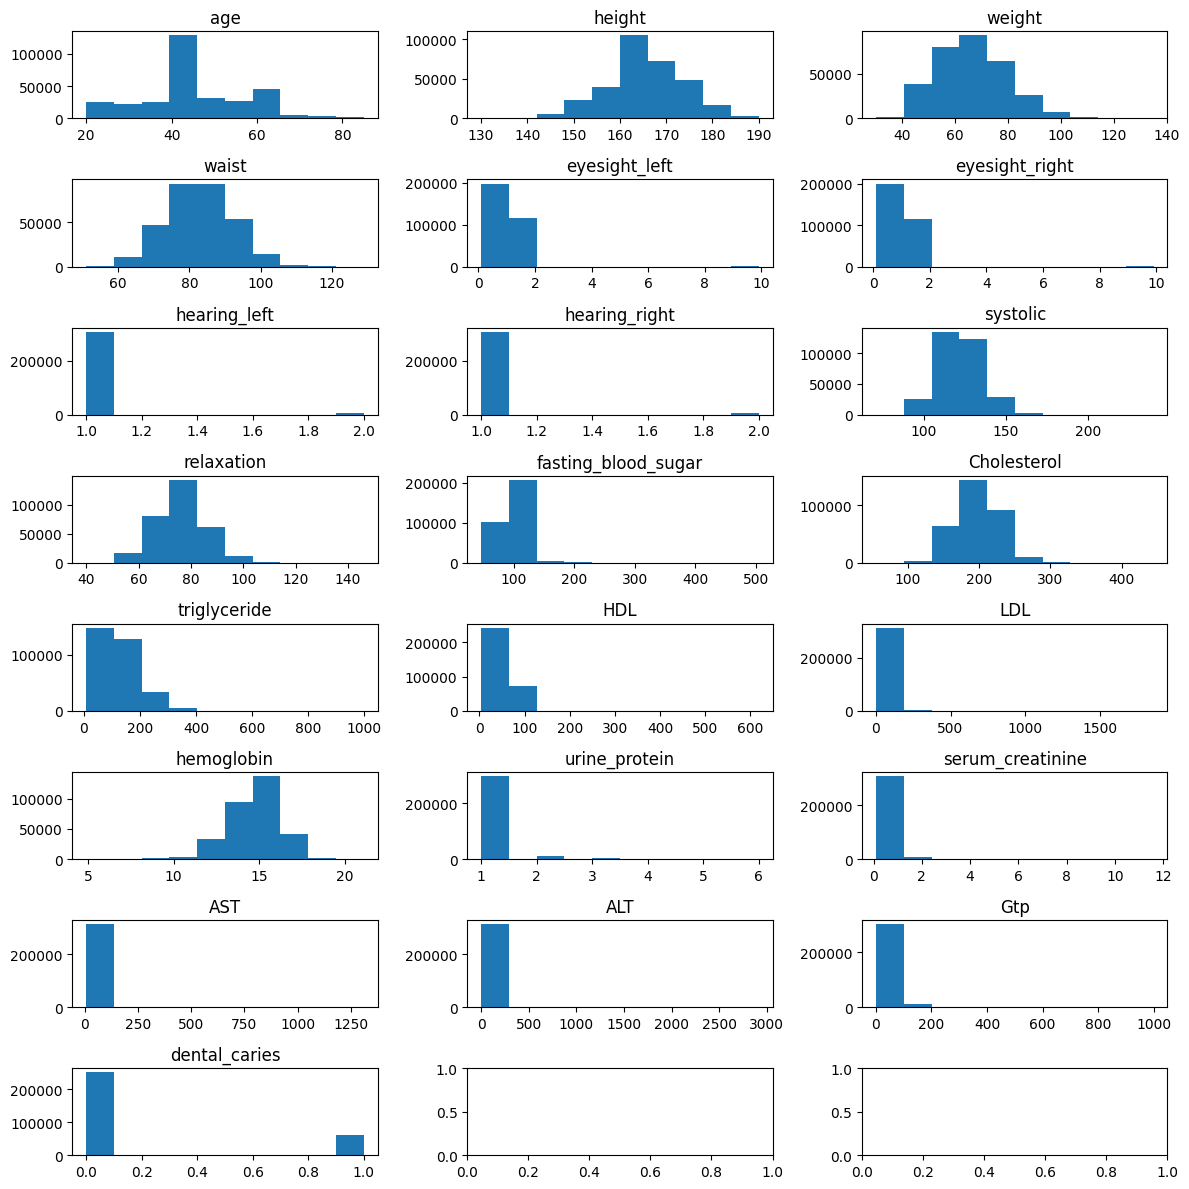

In [20]:
fig, ax = plt.subplots(int((len(alls)/3))+1, 3, figsize = (12, 12))
ax = ax.flatten()

for i, column in enumerate(alls):  
    ax[i].hist(concat_df[column])
    ax[i].set_title(column)
    
plt.tight_layout()

In [21]:
concat_df[all_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
age,314604.0,44.332100,11.899401,20.0,40.0,40.0,55.0,85.0
height,314604.0,165.154187,8.888297,130.0,160.0,165.0,170.0,190.0
weight,314604.0,66.937865,12.630126,30.0,55.0,65.0,75.0,135.0
waist,314604.0,82.855393,9.009364,51.0,77.0,83.0,89.0,129.0
eyesight_left,314604.0,1.006412,0.415041,0.1,0.8,1.0,1.2,9.9
eyesight_right,314604.0,1.001547,0.406531,0.1,0.8,1.0,1.2,9.9
hearing_left,314604.0,1.024326,0.154059,1.0,1.0,1.0,1.0,2.0
hearing_right,314604.0,1.024024,0.153123,1.0,1.0,1.0,1.0,2.0
systolic,314604.0,122.339446,12.899093,71.0,113.0,121.0,130.0,240.0
relaxation,314604.0,76.723538,9.118498,40.0,70.0,78.0,82.0,146.0


In [22]:
def view_cat_target_feature_corr(
    df: pd.DataFrame,
    feature: str,
    target: str,
    is_numeric: bool=False,
    bins: int|list|None=None,
    labels: list|None=None
) -> pd.DataFrame:
    df = df[[feature, target]].copy()
    df = df[df[target].isna()==False]
    if is_numeric:
        if isinstance(bins, int) and bins>=2:
            if labels is None:
                labels = [i for i in range(bins)]
            else:
                if len(labels) > bins:
                    labels = labels[:bins]
                elif len(labels) < bins:
                    add_labels = [i for i in range(len(labels), bins)]
                    labels += add_labels
            df[f'cut_of_{feature}'] = pd.cut(df[feature], bins=bins, labels=labels)
        elif isinstance(bins, list) and len(bins)>=3:
            num_bins = len(bins) - 1
            if labels is None:
                labels = [i for i in range(num_bins)]
            else:
                if len(labels) > num_bins:
                    labels = labels[:num_bins]
                elif len(labels) < num_bins:
                    add_labels = [i for i in range(len(labels), num_bins)]
                    labels += add_labels
            df[f'cut_of_{feature}'] = pd.cut(df[feature], bins=bins, labels=labels)
        else:
            num_bins = 10
            if labels is None:
                labels = [i for i in range(num_bins)]
            else:
                if len(labels) > num_bins:
                    labels = labels[:num_bins]
                elif len(labels) < num_bins:
                    add_labels = [i for i in range(len(labels), num_bins)]
                    labels += add_labels
            df[f'cut_of_{feature}'] = pd.cut(df[feature], bins=bins, labels=labels)
    else:
        df[f'cut_of_{feature}'] = df[feature]
    
    feature_dict = dict()
    total = df[f'cut_of_{feature}'].value_counts()
    view_idx = df[target].value_counts().index.tolist()
    for idx in view_idx:
        label = df[df[target]==idx][f'cut_of_{feature}'].value_counts()
        feature_dict[idx] = label/total*100
    
    out_df = pd.DataFrame(feature_dict, columns=view_idx)
    return out_df

In [23]:
view_cat_target_feature_corr(concat_df, 'age', 'smoking', is_numeric=True, bins=6)

,0.0,1.0
cut_of_age,,
0,46.151792,53.848208
1,51.018784,48.981216
2,59.922067,40.077933
3,69.545350,30.454650
4,77.802597,22.197403
5,85.981934,14.018066


In [24]:
view_cat_target_feature_corr(concat_df, 'height', 'smoking', is_numeric=True, bins=6)

,0.0,1.0
cut_of_height,,
0,97.833935,2.166065
1,96.744659,3.255341
2,83.594482,16.405518
3,42.398348,57.601652
4,36.623827,63.376173
5,39.501953,60.498047


In [25]:
view_cat_target_feature_corr(concat_df, 'weight', 'smoking', is_numeric=True, bins=6)

,0.0,1.0
cut_of_weight,,
0,93.250247,6.749753
1,69.662103,30.337897
2,43.042351,56.957649
3,36.554479,63.445521
4,33.978703,66.021297
5,40.677966,59.322034


In [26]:
view_cat_target_feature_corr(concat_df, 'waist', 'smoking', is_numeric=True, bins=6)

,0.0,1.0
cut_of_waist,,
0,92.578375,7.421625
1,75.324152,24.675848
2,53.140560,46.859440
3,43.272232,56.727768
4,38.983051,61.016949
5,40.677966,59.322034


In [27]:
concat_df['BMI'] = concat_df['weight'] / ((concat_df['height']/100)**2)
concat_df['ratio_height_waist'] = concat_df['height'] / concat_df['waist']

In [28]:
concat_df[['BMI', 'ratio_height_waist']].describe()

,BMI,ratio_height_waist
count,314604.000000,314604.000000
mean,24.410149,2.012469
std,3.384281,0.203495
min,10.380623,1.252937
25%,22.038567,1.875000
50%,24.221453,2.000000
75%,26.159334,2.137931
max,48.888889,3.333333


In [29]:
view_cat_target_feature_corr(concat_df, 'BMI', 'smoking', is_numeric=True, bins=6)

,0.0,1.0
cut_of_BMI,,
0,62.500000,37.500000
1,65.643655,34.356345
2,53.096433,46.903567
3,50.016983,49.983017
4,46.592593,53.407407
5,51.724138,48.275862


In [30]:
view_cat_target_feature_corr(concat_df, 'ratio_height_waist', 'smoking', is_numeric=True, bins=4)

,0.0,1.0
cut_of_ratio_height_waist,,
1,55.786567,44.213433
0,60.507784,39.492216
2,68.420765,31.579235
3,64.102564,35.897436


In [31]:
concat_df['eyesight_left'] = concat_df['eyesight_left'].clip(0,2.2)
concat_df['eyesight_right'] = concat_df['eyesight_right'].clip(0,2.2)

In [32]:
view_cat_target_feature_corr(concat_df, 'eyesight_left', 'smoking', is_numeric=True, bins=5)


,0.0,1.0
cut_of_eyesight_left,,
2,54.571804,45.428196
1,63.180048,36.819952
3,47.759775,52.240225
0,68.943079,31.056921
4,48.656716,51.343284


In [33]:
view_cat_target_feature_corr(concat_df, 'hearing_left', 'smoking')

,0.0,1.0
cut_of_hearing_left,,
1,57.219658,42.780342
2,68.716520,31.283480


In [34]:
concat_df['ratio_eyesight_hearing'] = (concat_df['eyesight_left']+concat_df['eyesight_right'])/(concat_df['hearing_left']+concat_df['hearing_right'])
concat_df['ratio_eyesight'] = concat_df['eyesight_left'] / concat_df['eyesight_right']
concat_df['sum_eyesight_hearing'] = (concat_df['eyesight_left']+concat_df['eyesight_right'])+(concat_df['hearing_left']+concat_df['hearing_right'])
concat_df['eyesight_max'] = concat_df[['eyesight_left', 'eyesight_right']].max(axis=1)

In [35]:
view_cat_target_feature_corr(concat_df, 'systolic', 'smoking', is_numeric=True, bins=6)


,0.0,1.0
cut_of_systolic,,
0,80.731765,19.268235
1,58.295720,41.704280
2,54.751382,45.248618
3,64.248927,35.751073
4,61.904762,38.095238
5,40.000000,60.000000


In [36]:
view_cat_target_feature_corr(concat_df, 'relaxation', 'smoking', is_numeric=True, bins=6)

,0.0,1.0
cut_of_relaxation,,
2,52.630590,47.369410
1,63.172699,36.827301
3,53.909774,46.090226
0,84.460695,15.539305
4,56.250000,43.750000
5,45.454545,54.545455


In [37]:
concat_df['fasting_blood_sugar'] = concat_df['fasting_blood_sugar'].clip(0,410)
concat_df['triglyceride'] = concat_df['triglyceride'].clip(0,610) 
concat_df['HDL'] = concat_df['HDL'].clip(0,210)
concat_df['LDL'] = concat_df['LDL'].clip(0,550)

In [38]:
view_cat_target_feature_corr(concat_df, 'fasting_blood_sugar', 'smoking', is_numeric=True, bins=6)

,0.0,1.0
cut_of_fasting_blood_sugar,,
0,59.256626,40.743374
1,50.422848,49.577152
2,42.857143,57.142857
3,32.000000,68.000000
4,30.769231,69.230769
5,13.333333,86.666667


In [39]:
view_cat_target_feature_corr(concat_df, 'triglyceride', 'smoking', is_numeric=True, bins=6)

,0.0,1.0
cut_of_triglyceride,,
0,72.562624,27.437376
1,47.536221,52.463779
2,32.312452,67.687548
3,26.863085,73.136915
4,50.000000,50.000000
5,0.000000,100.000000


In [40]:
view_cat_target_feature_corr(concat_df, 'HDL', 'smoking', is_numeric=True, bins=6)

,0.0,1.0
cut_of_HDL,,
0,37.071811,62.928189
1,55.726493,44.273507
2,78.550164,21.449836
3,75.000000,25.000000
4,80.000000,20.000000
5,100.000000,0.000000


In [41]:
view_cat_target_feature_corr(concat_df, 'LDL', 'smoking', is_numeric=True, bins=6)


,0.0,1.0
cut_of_LDL,,
1,58.375724,41.624276
0,54.226682,45.773318
2,67.114997,32.885003
5,62.500000,37.500000
3,66.666667,33.333333
4,0.000000,100.000000


In [42]:
concat_df['ratio_HDL_LDL'] = concat_df['HDL'] / concat_df['LDL']
concat_df['ratio_HDL_LDL'] = concat_df['ratio_HDL_LDL'].clip(0,1.6)

In [43]:
view_cat_target_feature_corr(concat_df, 'ratio_HDL_LDL', 'smoking', is_numeric=True, bins=6)

,0.0,1.0
cut_of_ratio_HDL_LDL,,
0,44.546735,55.453265
1,54.153812,45.846188
2,64.988949,35.011051
3,67.417447,32.582553
4,65.653858,34.346142
5,54.044381,45.955619


In [44]:
concat_df['serum_creatinine'] = concat_df['serum_creatinine'].clip(0,5)

In [45]:
view_cat_target_feature_corr(concat_df, 'urine_protein', 'smoking')

,0.0,1.0
cut_of_urine_protein,,
1,57.204154,42.795846
2,63.217014,36.782986
3,62.437276,37.562724
4,58.359621,41.640379
5,64.285714,35.714286
6,81.818182,18.181818


In [46]:
for col in ['AST', 'ALT']:
    concat_df[col] = concat_df[col].clip(0,600)
concat_df['Gtp'] = concat_df['Gtp'].clip(0,900)

In [47]:
view_cat_target_feature_corr(concat_df, 'AST', 'smoking', is_numeric=True, bins=6)

,0.0,1.0
cut_of_AST,,
0,57.516547,42.483453
1,41.116751,58.883249
2,31.578947,68.421053
3,75.000000,25.000000
4,NaN,NaN
5,53.846154,46.153846


In [48]:
view_cat_target_feature_corr(concat_df, 'ALT', 'smoking', is_numeric=True, bins=6)

,0.0,1.0
cut_of_ALT,,
0,57.566112,42.433888
1,45.264207,54.735793
2,45.098039,54.901961
5,41.176471,58.823529
3,83.333333,16.666667
4,50.000000,50.000000


In [49]:
view_cat_target_feature_corr(concat_df, 'Gtp', 'smoking', is_numeric=True, bins=6)

,0.0,1.0
cut_of_Gtp,,
0,57.924342,42.075658
1,24.683247,75.316753
2,26.388889,73.611111
3,29.000000,71.000000
4,36.363636,63.636364
5,20.000000,80.000000


In [50]:
concat_df['sum_AST_ALT_Gtp'] = concat_df['AST'] + concat_df['ALT'] + concat_df['Gtp']
concat_df['ratio_AST_ALT'] = concat_df['AST'] / concat_df['ALT']
concat_df['ratio_AST_ALT'] = concat_df['ratio_AST_ALT'].clip(0,4)

In [51]:
view_cat_target_feature_corr(concat_df, 'ratio_AST_ALT', 'smoking', is_numeric=True, bins=6)


,0.0,1.0
cut_of_ratio_AST_ALT,,
0,38.945440,61.054560
1,55.660766,44.339234
2,73.983581,26.016419
3,74.831920,25.168080
4,69.205835,30.794165
5,67.117117,32.882883


Change type


In [52]:
int_cols = concat_df.select_dtypes(include='int64').columns.tolist()
concat_df[int_cols] = concat_df[int_cols].astype('int16')

In [53]:
float_cols = concat_df.select_dtypes(include='float64').columns.tolist()
concat_df[float_cols] = concat_df[float_cols].astype('float32')

Split And Merge

In [54]:
train_df = concat_df[(concat_df['Source']=='Competition')&(concat_df['DSType']=='Train')]
test_df = concat_df[(concat_df['Source']=='Competition')&(concat_df['DSType']=='Test')]
original_train_df = concat_df[(concat_df['Source']=='Original')&(concat_df['DSType']=='Train')]

In [55]:
concat_df = pd.concat([train_df, original_train_df]).copy()

In [56]:
concat_df['smoking'] = concat_df['smoking'].astype('int8')

In [57]:
input_cols = concat_df.columns.tolist()
input_cols.remove('Source')
input_cols.remove('DSType')
input_cols.remove('smoking')

In [58]:
inputs, targets = concat_df[input_cols], concat_df['smoking']


MUtual Info

In [59]:
%%time
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(inputs, targets, random_state=42)
mutual_info = pd.Series(mutual_info)
mutual_info.index = inputs.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )

CPU times: total: 54.8 s
Wall time: 57.1 s


In [60]:
import pandas as pd
mutual_info.style.background_gradient('cool')


,Numerical_Feature_MI
BMI,0.133474
height,0.133007
hemoglobin,0.128294
ratio_height_waist,0.117259
Gtp,0.097226
weight,0.076381
triglyceride,0.067705
sum_AST_ALT_Gtp,0.061421
serum_creatinine,0.060811
waist,0.042015


In [61]:
original_features = concat_df.columns.tolist()[:22]
all_features = input_cols

In [62]:
importance_features_1 = original_features + ['BMI']
importance_features_2 = importance_features_1 + ['ratio_AST_ALT']
importance_features_3 = importance_features_2 + ['sum_AST_ALT_Gtp']
importance_features_4 = importance_features_3 + ['ratio_height_waist']

Training Model

In [63]:
def cross_validation(model, cv, inputs, targets, test_inputs=None, need_print=False):
    train_scores = []
    val_scores = []
    if test_inputs is not None:
        test_preds = np.zeros(len(test_inputs))
    else:
        test_preds = np.zeros(len(inputs))
    for fold, (train_idx, val_idx) in enumerate(cv.split(inputs, targets)):
        X_train = inputs.iloc[train_idx].reset_index(drop=True)
        y_train = targets.iloc[train_idx].reset_index(drop=True)
        X_val = inputs.iloc[val_idx].reset_index(drop=True)
        y_val = targets.iloc[val_idx].reset_index(drop=True)

        model.fit(X_train, y_train)

        train_pred = model.predict_proba(X_train)[:,1]
        train_score = roc_auc_score(y_train, train_pred)
        train_scores.append(train_score)
        val_pred = model.predict_proba(X_val)[:,1]
        val_score = roc_auc_score(y_val, val_pred)
        val_scores.append(val_score)

        if need_print:
            print(f'Fold {fold}: train_score = {train_score:.5f}, val_score = {val_score:.5f}')

        if test_inputs is not None:
            test_pred = model.predict_proba(test_inputs)[:,1]
            test_preds += test_pred/cv.get_n_splits()
            
    m_train_score = np.mean(train_scores)
    s_train_score = np.std(train_scores)
    m_val_score = np.mean(val_scores)
    s_val_score = np.std(val_scores)
    
    msg = f'{m_val_score:.7f} ± {s_val_score:.7f}'
    
    if need_print:
        print(f'Train score: {m_train_score:.7f} ± {s_train_score:.7f} | Val score: {m_val_score:.7f} ± {s_val_score:.7f}')
    return test_preds, msg

In [64]:
def test_with_models(models: dict, features: dict, 
                     df: pd.DataFrame, target: str, cv):
    result = dict()
    result['Model'] = []
    for feature, _ in features.items():
        result[f'Score with {feature} features'] = []
    targets = df[target]
    for name, model in models.items():
        result['Model'].append(name)
        for f_name, feature in features.items():
            inputs = df[feature]
            _, msg = cross_validation(model, cv, 
                                         inputs, targets,
                                         test_inputs=None, 
                                         need_print=False)
            result[f'Score with {f_name} features'].append(msg)
    
    return pd.DataFrame(result) 

In [65]:
classifiers = {
    'RandomForest': RandomForestClassifier(n_jobs=-1),
    'XGB': XGBClassifier(n_jobs=-1),
    'LGBM' : LGBMClassifier(n_jobs=-1,verbose=-1),
    'CAT': CatBoostClassifier(logging_level='Silent')
}
features = {
    'all': all_features,
    'original': original_features,
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [66]:
%%time
test_with_models(classifiers, features, train_df, 'smoking', cv)

CPU times: total: 42min 45s
Wall time: 2min 20s


,Model,Score with all features,Score with original features
0,RandomForest,0.8546211 ± 0.0018592,0.8568980 ± 0.0020109
1,XGB,0.8637701 ± 0.0010752,0.8650315 ± 0.0010643
2,LGBM,0.8646485 ± 0.0010644,0.8650397 ± 0.0009495
3,CAT,0.8680456 ± 0.0010511,0.8686561 ± 0.0010450


In [67]:
classifiers = {
    'RandomForest': RandomForestClassifier(n_jobs=-1),
    'CAT': CatBoostClassifier(logging_level='Silent')
}
features = {
    'all': all_features,
    'original': original_features,
    'importance 1': importance_features_1,
    'importance 2': importance_features_2,
    'importance 3': importance_features_3,
    'importance 4': importance_features_4
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [68]:
%%time
test_with_models(classifiers, features, train_df, 'smoking', cv)

CPU times: total: 2h 17min 52s
Wall time: 7min 59s


,Model,Score with all features,Score with original features,Score with importance 1 features,Score with importance 2 features,Score with importance 3 features,Score with importance 4 features
0,RandomForest,0.8551188 ± 0.0021948,0.8566223 ± 0.0014879,0.8566186 ± 0.0015043,0.8565589 ± 0.0021621,0.8563068 ± 0.0017111,0.8562119 ± 0.0018164
1,CAT,0.8680456 ± 0.0010511,0.8686561 ± 0.0010450,0.8687726 ± 0.0010618,0.8685820 ± 0.0009034,0.8684148 ± 0.0009605,0.8684218 ± 0.0009535


In [69]:
inputs, targets = train_df[importance_features_1], train_df['smoking']
test_inputs = test_df[importance_features_1]

In [70]:
scores = dict()
scores['Classifier'] = []
scores['Train Score'] = []
scores['Val Score'] = []
scores['Test Score'] = []

RandomForest

In [71]:
%%time
clf = RandomForestClassifier(n_jobs=-1)
test_preds, _ = cross_validation(clf, cv, inputs, targets, 
                                 need_print=True, test_inputs=test_inputs)


Fold 0: train_score = 1.00000, val_score = 0.85571
Fold 1: train_score = 1.00000, val_score = 0.85759
Fold 2: train_score = 1.00000, val_score = 0.85727
Fold 3: train_score = 1.00000, val_score = 0.85440
Fold 4: train_score = 1.00000, val_score = 0.85781
Train score: 1.0000000 ± 0.0000000 | Val score: 0.8565545 ± 0.0013067
CPU times: total: 5min 8s
Wall time: 30.2 s


In [72]:
sub_df['smoking'] = test_preds
sub_df.to_csv("C:/Users/divya/OneDrive/Desktop/sub_rf.csv", index=False)



In [73]:
scores['Classifier'].append('RF without tuning')
scores['Train Score'].append(1.00000)
scores['Val Score'].append(0.85743)
scores['Test Score'].append(0.86155)

XGB

In [74]:
%%time
clf = XGBClassifier(n_jobs=-1)
test_preds, _ = cross_validation(clf, cv, inputs, targets, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_score = 0.90620, val_score = 0.86360
Fold 1: train_score = 0.90533, val_score = 0.86663
Fold 2: train_score = 0.90542, val_score = 0.86542
Fold 3: train_score = 0.90676, val_score = 0.86373
Fold 4: train_score = 0.90526, val_score = 0.86517
Train score: 0.9057958 ± 0.0005884 | Val score: 0.8649075 ± 0.0011308
CPU times: total: 41.7 s
Wall time: 5.37 s


In [75]:
sub_df['smoking'] = test_preds
sub_df.to_csv("C:/Users/divya/OneDrive/Desktop/sub_xbg.csv", index=False)

In [76]:
scores['Classifier'].append('XGB without tuning')
scores['Train Score'].append(0.90576)
scores['Val Score'].append(0.86498)
scores['Test Score'].append(0.86967)

In [77]:
param_dis = {
    'n_estimators': np.arange(100,600,150),
    'max_depth': np.arange(8,17,2),
    'learning_rate': loguniform(0.009,0.25),
    'reg_lambda': loguniform(1e-5,5),
    'subsample': loguniform(0.5,1),
    'min_child_weight': loguniform(0.4,5),
    'eval_metric': ['auc'],
    'tree_method': ['hist'],
    'colsample_bytree': loguniform(0.25,1),
    'nthread': [2],
    'n_jobs': [-1],
    'device': ['cuda'],
    'max_bin': [256,512,1024]
}

In [78]:
'''%%time
search = RandomizedSearchCV(XGBClassifier(), param_dis, 
                            n_iter=170, refit=True, 
                            scoring = 'roc_auc',
                            cv=cv, verbose=3)
search.fit(inputs, targets)'''

"%%time\nsearch = RandomizedSearchCV(XGBClassifier(), param_dis, \n                            n_iter=170, refit=True, \n                            scoring = 'roc_auc',\n                            cv=cv, verbose=3)\nsearch.fit(inputs, targets)"

In [79]:
xgb_best_params = {
 'colsample_bytree': 0.32227031188285826,
 'device': 'cuda',
 'eval_metric': 'auc',
 'learning_rate': 0.036842897398501565,
 'max_bin': 256,
 'max_depth': 12,
 'min_child_weight': 1.1072532554465817,
 'n_estimators': 550,
 'n_jobs': -1,
 'nthread': 2,
 'reg_lambda': 3.8673729494085682,
 'subsample': 0.8118923157692949,
 'tree_method': 'hist'
}

In [80]:
%%time
clf = XGBClassifier(**xgb_best_params)
test_preds, _ = cross_validation(clf, cv, inputs, targets, 
                                 need_print=True, test_inputs=test_inputs)

C:\Users\divya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [12:43:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\divya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [12:43:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Fold 0: train_score = 0.98764, val_score = 0.86904


C:\Users\divya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [12:43:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\divya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [12:43:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1: train_score = 0.98682, val_score = 0.87235


C:\Users\divya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [12:44:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\divya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [12:44:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2: train_score = 0.98654, val_score = 0.86989


C:\Users\divya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [12:44:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\divya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [12:44:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Fold 3: train_score = 0.98710, val_score = 0.86871


C:\Users\divya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [12:45:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\divya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [12:45:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4: train_score = 0.98710, val_score = 0.86987
Train score: 0.9870387 ± 0.0003665 | Val score: 0.8699725 ± 0.0012738
CPU times: total: 5min 10s
Wall time: 2min 39s


In [81]:
sub_df['smoking'] = test_preds
sub_df.to_csv("C:/Users/divya/OneDrive/Desktop/sub_xgb_tuning.csv", index=False)

In [82]:
scores['Classifier'].append('XGB with tuning')
scores['Train Score'].append(0.98629)
scores['Val Score'].append(0.87027)
scores['Test Score'].append(0.87273)

LGBM

In [83]:
%%time
clf = LGBMClassifier(n_jobs=-1, verbose=-1)
test_preds, _ = cross_validation(clf, cv, inputs, targets, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_score = 0.87726, val_score = 0.86466
Fold 1: train_score = 0.87682, val_score = 0.86635
Fold 2: train_score = 0.87697, val_score = 0.86546
Fold 3: train_score = 0.87723, val_score = 0.86345
Fold 4: train_score = 0.87648, val_score = 0.86565
Train score: 0.8769532 ± 0.0002876 | Val score: 0.8651160 ± 0.0009907
CPU times: total: 1min 40s
Wall time: 13.1 s


In [84]:
sub_df['smoking'] = test_preds
sub_df.to_csv("C:/Users/divya/OneDrive/Desktop/sub_lgbm.cs", index=False)

In [85]:
scores['Classifier'].append('LGBM without tuning')
scores['Train Score'].append(0.87695)
scores['Val Score'].append(0.86512)
scores['Test Score'].append(0.86604)

In [86]:
param_dis = {
    'num_leaves': np.arange(32,300,7),
    'n_jobs': [-1],
    'reg_lambda': loguniform(1e-5,4),
    'reg_alpha': loguniform(1e-5,4),
    'n_estimators': np.arange(50,541,40),
    'learning_rate': loguniform(0.001,0.2),
    'max_depth': np.arange(15,55,4),
    'min_split_gain': loguniform(1e-8,0.1),
    'min_child_weight': loguniform(1e-4,0.1),
    'min_child_samples': np.arange(8,30,4),
    'subsample': loguniform(0.25,1),
    'colsample_bytree': loguniform(0.25,1),
    'random_state': [42],
    'verbose': [-1]
}

In [87]:
'''%%time
search = RandomizedSearchCV(LGBMClassifier(), param_dis, 
                            n_iter=150, refit=True,
                            scoring = 'roc_auc',
                            cv=cv, verbose=3)
search.fit(inputs, targets)'''

"%%time\nsearch = RandomizedSearchCV(LGBMClassifier(), param_dis, \n                            n_iter=150, refit=True,\n                            scoring = 'roc_auc',\n                            cv=cv, verbose=3)\nsearch.fit(inputs, targets)"

In [88]:
lgbm_best_params = {
 'colsample_bytree': 0.3637387574466506,
 'learning_rate': 0.028872876905286234,
 'max_depth': 27,
 'min_child_samples': 8,
 'min_child_weight': 0.0002606081742795405,
 'min_split_gain': 9.253821462797391e-07,
 'n_estimators': 450,
 'n_jobs': -1,
 'num_leaves': 298,
 'random_state': 42,
 'reg_alpha': 0.20993841155679813,
 'reg_lambda': 0.15523903807437986,
 'subsample': 0.43772525984845173,
 'verbose': -1
}

In [89]:
%%time
clf = LGBMClassifier(**lgbm_best_params)
test_preds, _ = cross_validation(clf, cv, inputs, targets, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_score = 0.95822, val_score = 0.86897
Fold 1: train_score = 0.95777, val_score = 0.87181
Fold 2: train_score = 0.95794, val_score = 0.87026
Fold 3: train_score = 0.95778, val_score = 0.86809
Fold 4: train_score = 0.95822, val_score = 0.87017
Train score: 0.9579853 ± 0.0002005 | Val score: 0.8698583 ± 0.0012623
CPU times: total: 31min 40s
Wall time: 3min 21s


In [90]:
sub_df['smoking'] = test_preds
sub_df.to_csv("C:/Users/divya/OneDrive/Desktop/sub_lgbm_tuning.csv", index=False)

In [91]:
scores['Classifier'].append('LGBM with tuning')
scores['Train Score'].append(0.95799)
scores['Val Score'].append(0.86986)
scores['Test Score'].append(0.87166)


CatBoost

In [92]:
%%time
clf = CatBoostClassifier(logging_level='Silent')
test_preds, _ = cross_validation(clf, cv, inputs, targets, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_score = 0.90015, val_score = 0.86747
Fold 1: train_score = 0.89849, val_score = 0.87020
Fold 2: train_score = 0.89937, val_score = 0.86921
Fold 3: train_score = 0.89945, val_score = 0.86762
Fold 4: train_score = 0.89952, val_score = 0.86937
Train score: 0.8993954 ± 0.0005305 | Val score: 0.8687726 ± 0.0010618
CPU times: total: 15min 25s
Wall time: 1min 9s


In [93]:
sub_df['smoking'] = test_preds
sub_df.to_csv("C:/Users/divya/OneDrive/Desktop/sub_cat.csv", index=False)

In [94]:
scores['Classifier'].append('CAT without tuning')
scores['Train Score'].append(0.89927)
scores['Val Score'].append(0.86877)
scores['Test Score'].append(0.87077)

In [95]:
param_dis = {
    'eval_metric': ['AUC'],
    'iterations': np.arange(750,2000,250),
    'learning_rate': loguniform(0.008,0.21),
    'random_seed': [42],
    'l2_leaf_reg': loguniform(0.8,50),
    'bagging_temperature': loguniform(1e-4,1),
    'random_strength': np.arange(1,10),
    'depth': np.arange(6,10),
    'min_data_in_leaf': np.arange(1,5),
    'border_count': np.arange(24,256,50),
    'logging_level': ['Silent'],
    'task_type': ['GPU']
}

In [96]:
'''%%time
search = RandomizedSearchCV(CatBoostClassifier(), param_dis, 
                            n_iter=85, refit=True,
                            scoring = 'roc_auc',
                            cv=cv, verbose=3)
search.fit(inputs, targets)'''

"%%time\nsearch = RandomizedSearchCV(CatBoostClassifier(), param_dis, \n                            n_iter=85, refit=True,\n                            scoring = 'roc_auc',\n                            cv=cv, verbose=3)\nsearch.fit(inputs, targets)"

In [97]:
cat_best_params = {
 'bagging_temperature': 0.4405921169223117,
 'border_count': 224,
 'depth': 6,
 'eval_metric': 'AUC',
 'iterations': 1750,
 'l2_leaf_reg': 9.61900884878948,
 'learning_rate': 0.049714163879930794,
 'logging_level': 'Silent',
 'min_data_in_leaf': 3,
 'random_seed': 42,
 'random_strength': 9,
 'task_type': 'GPU'
}

In [98]:
from catboost import CatBoostClassifier


cat_best_params = {k: v for k, v in cat_best_params.items() if k != "task_type"}
clf = CatBoostClassifier(**cat_best_params, task_type="CPU")
test_preds, _ = cross_validation(clf, cv, inputs, targets, 
                                 need_print=True, test_inputs=test_inputs)


Fold 0: train_score = 0.89743, val_score = 0.86733
Fold 1: train_score = 0.89543, val_score = 0.87060
Fold 2: train_score = 0.89609, val_score = 0.86915
Fold 3: train_score = 0.89569, val_score = 0.86737
Fold 4: train_score = 0.89644, val_score = 0.86938
Train score: 0.8962155 ± 0.0006958 | Val score: 0.8687636 ± 0.0012581


In [99]:
sub_df['smoking'] = test_preds
sub_df.to_csv("C:/Users/divya/OneDrive/Desktop/sub_cat_tuning.csv", index=False)

In [100]:
scores['Classifier'].append('CAT with tuning')
scores['Train Score'].append(0.89870)
scores['Val Score'].append(0.86932)
scores['Test Score'].append(0.87079)

In [101]:
int_cols = inputs.select_dtypes(include='int16').columns.tolist()

In [102]:
%%time
clf = CatBoostClassifier(**cat_best_params, cat_features=int_cols)
test_preds, _ = cross_validation(clf, cv, inputs, targets, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_score = 0.90832, val_score = 0.86874
Fold 1: train_score = 0.90534, val_score = 0.87314
Fold 2: train_score = 0.90616, val_score = 0.87178
Fold 3: train_score = 0.90559, val_score = 0.86943
Fold 4: train_score = 0.90630, val_score = 0.87218
Train score: 0.9063402 ± 0.0010519 | Val score: 0.8710542 ± 0.0016815
CPU times: total: 5h 23min 45s
Wall time: 37min 17s


In [103]:
sub_df['smoking'] = test_preds
sub_df.to_csv("C:/Users/divya/OneDrive/Desktop/sub_cat_tuning_cat.csv", index=False)

In [104]:
scores['Classifier'].append('CAT with tuning and cat features')
scores['Train Score'].append(0.89806)
scores['Val Score'].append(0.87141)
scores['Test Score'].append(0.87351)

Voting

In [105]:
ests = list()
ests.append(('rf', RandomForestClassifier(n_jobs=-1)))
ests.append(('xgb', XGBClassifier(**xgb_best_params)))
ests.append(('lgbm', LGBMClassifier(**lgbm_best_params)))
ests.append(('cat', CatBoostClassifier(**cat_best_params, cat_features=int_cols)))

In [106]:
weights = []
weights.append([0.05,0.4,0.15,0.4])
weights.append([0,0.4,0.1,0.5])
weights.append([0.02,0.33,0.1,0.55])
weights.append([0.02,0.3,0.08,0.6])
weights.append([0.02,0.35,0.13,0.5])

In [107]:
param_grid = {
    'voting': ['soft'],
    'weights': weights
}

In [108]:
'''%%time
search = GridSearchCV(VotingClassifier(ests), param_grid, 
                      refit=True, scoring = 'roc_auc',
                      cv=cv, verbose=3) 
search.fit(inputs, targets)'''

"%%time\nsearch = GridSearchCV(VotingClassifier(ests), param_grid, \n                      refit=True, scoring = 'roc_auc',\n                      cv=cv, verbose=3) \nsearch.fit(inputs, targets)"

In [109]:
%%time
weights = [0.02, 0.33, 0.1, 0.55]
clf = VotingClassifier(ests, voting='soft', weights=weights)
test_preds, _ = cross_validation(clf, cv, inputs, targets,
                                 need_print=True, test_inputs=test_inputs)

NameError: name 'VotingClassifier' is not defined

In [110]:
sub_df['smoking'] = test_preds
sub_df.to_csv("C:/Users/divya/OneDrive/Desktop/sub_02_33_10_55.csv", index=False)

In [111]:
scores['Classifier'].append('Voting RF(2), XGB(33), LGBM(10), CAT(55)')
scores['Train Score'].append(0.95093)
scores['Val Score'].append(0.87309)
scores['Test Score'].append(0.87460)

Review

In [112]:
pd.DataFrame(scores).style.background_gradient('cool')

,Classifier,Train Score,Val Score,Test Score
0,RF without tuning,1.000000,0.857430,0.861550
1,XGB without tuning,0.905760,0.864980,0.869670
2,XGB with tuning,0.986290,0.870270,0.872730
3,LGBM without tuning,0.876950,0.865120,0.866040
4,LGBM with tuning,0.957990,0.869860,0.871660
5,CAT without tuning,0.899270,0.868770,0.870770
6,CAT with tuning,0.898700,0.869320,0.870790
7,CAT with tuning and cat features,0.898060,0.871410,0.873510
8,"Voting RF(2), XGB(33), LGBM(10), CAT(55)",0.950930,0.873090,0.874600


In [113]:
sub_df = pd.read_csv("C:/Users/divya/OneDrive/Desktop/sub_02_33_10_55.csv")
sub_df.to_csv("C:/Users/divya/OneDrive/Desktop/submission.csv", index=False)

In [114]:
import joblib
# Save the best model
joblib.dump(grid.best_estimator_, "smoking_model.pkl")


['smoking_model.pkl']